In [1]:
import rich
from dotenv import load_dotenv, find_dotenv
import os

# 自动向上查找 .env 文件
load_dotenv(find_dotenv())
modelName = os.getenv('OPENAI_MODEL')
print(modelName)

doubao-1-5-pro-256k-250115


# 1、构建一个基础聊天Agent

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


# 创建图的时候，第一步就是定义状态机
class State(TypedDict):
    # 消息的类型为 “list”。'add_messages' 函数
    # 定义如何更新此状态键
    # （在本例中，它将消息附加到列表中，而不是覆盖它们）就是每次人机聊天的请求响应都会在这个messages以add方式存储list
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

# 2、添加一个节点

In [ ]:
from langchain.chat_models import init_chat_model

llm = init_chat_model(model=f"openai:{modelName}")


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# 为这个图添加一个可用节点
graph_builder.add_node("chatbot", chatbot)

In [ ]:
graph_builder.add_edge(START, "chatbot")  # graph_builder.set_entry_point("chatbot")

In [ ]:
graph_builder.add_edge("chatbot", END)

In [ ]:
graph = graph_builder.compile()

In [ ]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))  # 可能会超时，需要开启代理

In [ ]:
for event in graph.stream({"messages": [{"role": "user", "content": "你是谁"}]}):
    for value in event.values():
        print("Assistant:", value["messages"][-1].content)


# 3、为Agent绑定工具

In [ ]:
from langchain_core.tools import tool


########### 定义工具
@tool
def get_personal_info(name: str) -> dict:
    """
        通过名称获取个人信息
    :param name:
    :return:
    """
    personal_info = {
        "love": "打篮球",
        "age": "18"
    }
    return personal_info


######### 创建图
from langchain.chat_models import init_chat_model

llm = init_chat_model(model=f"openai:{modelName}")
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


# 定义状态机
class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

# 为模型创建工具
llm_with_tools = llm.bind_tools([get_personal_info])


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)


## 3.1 自定义图工具与路由

In [ ]:
import copy

graph_builder_1 = copy.deepcopy(graph_builder)
import json
from langchain_core.messages import ToolMessage


class BasicToolNode:
    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, sate: State):
        if messages := sate.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[get_personal_info])
graph_builder_1.add_node("tools", tool_node)

In [ ]:
def route_tools(
        state: State,
):
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# 创建条件路由
graph_builder_1.add_conditional_edges(
    "chatbot",
    route_tools,
    {"tools": "tools", END: END},
)
graph_builder_1.add_edge("tools", "chatbot")
graph_builder_1.add_edge(START, "chatbot")
graph_1 = graph_builder_1.compile()

In [ ]:
from IPython.display import Image, display

display(Image(graph_1.get_graph().draw_mermaid_png()))  # 可能会超时，需要开启代理

In [ ]:
graph_1.invoke({"messages": [{"role": "user", "content": "帮我获取小红的信息"}]})

## 3.2 内置节点与内置路由

In [ ]:
import copy

graph_builder_2 = copy.deepcopy(graph_builder)
from langgraph.prebuilt import ToolNode

tools = ToolNode([get_personal_info])
graph_builder_2.add_node("tools", tools)

In [ ]:
from langgraph.prebuilt import tools_condition

# 创建条件路由
graph_builder_2.add_conditional_edges(
    "chatbot",
    tools_condition,
    {"tools": "tools", END: END},
)
graph_builder_2.add_edge(START, "chatbot")
graph_builder_2.add_edge("tools", "chatbot")
graph_2 = graph_builder_2.compile()

In [ ]:
from IPython.display import Image, display

display(Image(graph_2.get_graph().draw_mermaid_png()))

# 4、添加记忆

In [ ]:
from typing import Annotated
from langchain.chat_models import init_chat_model
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)
llm = init_chat_model(model=f"openai:{modelName}")


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

#### 添加内存操作
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph_by_in = graph_builder.compile(checkpointer=memory)

# 第一次发起询问
config = {"configurable": {"thread_id": "1"}}
events = graph_by_in.stream(
    {"messages": [{"role": "user", "content": "你好！我的名字叫稳稳"}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

# 第二次发起询问
events = graph_by_in.stream(
    {"messages": [{"role": "user", "content": "你还记得我的名字吗？"}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

# 5、添加人机交互

In [ ]:
from langchain_core.tools import tool
from typing_extensions import Annotated, TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
# ps 非常重要的点，导入这2个参数
from langgraph.types import interrupt, Command
from langchain.chat_models import init_chat_model

llm = init_chat_model(model=f"openai:{modelName}")


@tool("用户订阅酒店工具")
def book_hotel(*args,query: str,**kwargs) -> str:
    """
    用于处理酒店预订相关的请求。
    """
    print("*"*10,"进入")

    human_response = interrupt({"message": "好的请你填写酒店表单信息", "form_data": {"name": "", "age": ""}})

    print("*"*10,"离开")

    if human_response:
        return f"尊敬的{human_response['form_data']['name']},已经为您订阅酒店！"
    else:
        return "用户取消了预订"

tools = [book_hotel]
llm = llm.bind_tools(tools)
tools_node = ToolNode(tools)  # 适用于图的节点

### 创建图
class State(TypedDict):
    messages: Annotated[list, add_messages]

def chatbot(state: State):
    # 添加系统提示
    system_prompt = """你是一个智能助手。你有以下工具可用：

    工具使用规则：
    1. "用户订阅酒店工具" - 仅在用户明确想要预订酒店、查询酒店或讨论住宿相关问题时使用
    2. 对于一般性问题（如科学知识、天气、计算等），请直接回答，不要调用工具
    3. 如果用户的问题与可用工具无关，请礼貌地直接回答

    请仔细判断是否需要使用工具。"""
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    message = llm.invoke(messages)
    return {"messages": [message]}

graph_builder = StateGraph(State)
graph_builder.set_entry_point("chatbot")
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tools_node)
graph_builder.add_conditional_edges("chatbot", tools_condition)
graph_builder.add_edge("tools", "chatbot")

from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph_by_in = graph_builder.compile(checkpointer=memory)
from IPython.display import Image, display
display(Image(graph_by_in.get_graph().draw_mermaid_png()))  # 可能会超时，需要开启代理

In [ ]:
user_input = "太阳的体积"
config = {"configurable": {"thread_id": "1"}}
# 使用stream模式以便检测中断
events = graph_by_in.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values"
)
# 遍历事件
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()
graph_state = graph_by_in.get_state(config)

In [ ]:
user_input = "我想要定酒店"
config = {"configurable": {"thread_id": "1"}}
# 使用stream模式以便检测中断
events = graph_by_in.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values"
)
# 遍历事件
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()
graph_state = graph_by_in.get_state(config)

In [ ]:
# 用户填写表单
events = graph_by_in.stream(
    Command(resume={"form_data": {"name": "稳稳C9", "age": "18"}}),  # 传入用户填写的表单数据
    config,
    stream_mode="values"
)
# 处理恢复后的事件
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()
graph_state = graph_by_in.get_state(config)

In [ ]:
# 用户填写表单
events = graph_by_in.stream(
    {"messages": [{"role": "user", "content": "你是谁"}]},
    config,
    stream_mode="values"
)
# 处理恢复后的事件
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()
graph_state = graph_by_in.get_state(config)

In [ ]:
graph_history = list(graph_by_in.get_state_history(config))
for state in graph_history:
    print(state.next)
    print(state.config["configurable"]["checkpoint_id"])
    print()

In [ ]:
graph_by_in.get_state(config).interrupts

# 6、自定义状态机

In [ ]:
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from typing import Annotated, Optional
class State(TypedDict):
    messages: Annotated[list, add_messages]  # 对话消息列表
    applicant_name: Optional[str]            # 申请人姓名
    amount: Optional[float]                  # 申请金额
    purpose: Optional[str]                   # 申请用途
    approval_status: Optional[str]           # 审批状态：pending/approved/rejected
    approver_name: Optional[str]             # 审批人姓名

In [ ]:
from langchain_core.tools import tool
@tool
def evaluate_funding_request(applicant_name: str,amount: float,purpose: str) -> str:
    """
    评估财务拨款申请的合理性
    Args:
        applicant_name: 申请人姓名
        amount: 申请金额
        purpose: 申请用途
    Returns:
        评估结果
    """
    # 简单的风险评估
    if amount > 100000:
        risk_level = "高风险"
        suggestion = "需要详细说明资金用途"
    elif amount > 50000:
        risk_level = "中风险"
        suggestion = "建议提供项目计划"
    else:
        risk_level = "低风险"
        suggestion = "申请材料完整"

    evaluation = f"""
    📋 申请评估报告
    申请人: {applicant_name}
    申请金额: ¥{amount:,.2f}
    申请用途: {purpose}

    🔍 风险评估: {risk_level}
    💡 建议: {suggestion}
    """
    return evaluation

In [ ]:
from langchain_core.tools import InjectedToolCallId
from langgraph.types import interrupt, Command
from langchain_core.messages import ToolMessage
@tool
def financial_approval(applicant_name: str,amount: float,purpose: str,tool_call_id: Annotated[str, InjectedToolCallId]) -> str:
    """
    财务拨款审批工具

    Args:
        applicant_name: 申请人姓名
        amount: 申请金额，纯数字
        purpose: 申请用途
        tool_call_id: 工具调用ID（自动注入）
    Returns:
        审批结果
    """

    # 暂停执行，等待人工审批
    human_response = interrupt({
        "type": "financial_approval",
        "message": "财务拨款申请需要审批",
        "data": {
            "applicant_name": applicant_name,
            "amount": amount,
            "purpose": purpose
        },
        "options": ["批准申请", "拒绝申请"]
    })

    # 处理审批结果
    action = human_response.get("action", "拒绝申请")
    approver_name = human_response.get("approver_name", "未知审批人")
    comment = human_response.get("comment", "")

    if action == "批准申请":
        status = "approved"
        response = f"✅ 申请已批准\n审批人: {approver_name}\n批准金额: ¥{amount:,.2f}\n审批意见: {comment}"
    else:
        status = "rejected"
        response = f"❌ 申请已拒绝\n审批人: {approver_name}\n拒绝原因: {comment}"

    # 更新状态
    state_update = {
        "approval_status": status,
        "approver_name": approver_name,
        "messages": [ToolMessage(response, tool_call_id=tool_call_id)],
    }

    return Command(update=state_update)

In [ ]:
from langchain.chat_models import init_chat_model
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

# 初始化模型
llm = init_chat_model(f"openai:{modelName}")

# 绑定工具
tools = [evaluate_funding_request, financial_approval]
llm_with_tools = llm.bind_tools(tools)

# 定义聊天节点
def chatbot(state: State):
    """智能财务助手节点"""
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# 构建图
tool_node = ToolNode(tools=tools)
graph_builder = StateGraph(State)

# 添加节点和边
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)
graph_builder.add_conditional_edges("chatbot", tools_condition)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

# 编译图
graph = graph_builder.compile(checkpointer=MemorySaver())

In [ ]:
from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))  # 可能会超时，需要开启代理

In [51]:
config = {"configurable": {"thread_id": "rejection_demo_5"}}
user_request = "我是稳稳，申请拨款10万元用于购买豪华办公家具"
events = graph.stream(
    {"messages": [{"role": "user", "content": user_request}]},
    config,
    stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

我是稳稳，申请拨款10万元用于购买豪华办公家具
================================== Ai Message ==================================

首先调用 evaluate_funding_request 工具评估申请的合理性，再根据评估结果调用 financial_approval 工具进行审批。
Tool Calls:
  evaluate_funding_request (call_0r0dm6pt0jsdbs8dh0u18fw9)
 Call ID: call_0r0dm6pt0jsdbs8dh0u18fw9
  Args:
    applicant_name: 稳稳
    amount: 100000
    purpose: 购买豪华办公家具
================================= Tool Message =================================
Name: evaluate_funding_request


    📋 申请评估报告
    申请人: 稳稳
    申请金额: ¥100,000.00
    申请用途: 购买豪华办公家具

    🔍 风险评估: 中风险
    💡 建议: 建议提供项目计划
    
================================== Ai Message ==================================
Tool Calls:
  financial_approval (call_n5e0r77ipzsvdihcyan34j0t)
 Call ID: call_n5e0r77ipzsvdihcyan34j0t
  Args:
    applicant_name: 稳稳
    amount: 100000
    purpose: 购买豪华办公家具
    tool_call_id: 619052594411198464


In [52]:
graph_state = graph.get_state(config)

In [53]:
approval_feedback = {
        "action": "批准申请",
        "approver_name": "李财务经理",
        "comment": "采购符合预算，批准拨款"
    }
events = graph.stream(
        Command(resume=approval_feedback),
        config,
        stream_mode="values"
    )
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  financial_approval (call_n5e0r77ipzsvdihcyan34j0t)
 Call ID: call_n5e0r77ipzsvdihcyan34j0t
  Args:
    applicant_name: 稳稳
    amount: 100000
    purpose: 购买豪华办公家具
    tool_call_id: 619052594411198464
================================= Tool Message =================================
Name: financial_approval

✅ 申请已批准
审批人: 李财务经理
批准金额: ¥100,000.00
审批意见: 采购符合预算，批准拨款
================================== Ai Message ==================================

您的拨款申请已批准。审批人是李财务经理，批准金额为100,000元。审批意见为采购符合预算，批准拨款。同时，评估报告建议您提供项目计划，可能对未来的财务规划和项目执行有所帮助。


In [ ]:
graph_state2 = graph.get_state(config)

# 7、时间旅行

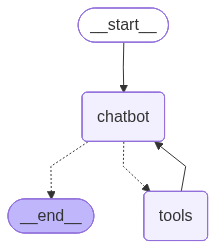

In [6]:
from typing import Annotated
from langchain_core.messages import BaseMessage
import random
from langchain.tools import tool
from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_openai import ChatOpenAI
from IPython.display import Image, display

######################### 创建模型 #########################
llm = ChatOpenAI(model=modelName)

######################### 初始化图 #########################

# 创建信息载体
class State(TypedDict):
    messages: Annotated[list, add_messages]
    test:str


# 创建图
graph_builder = StateGraph(State)

######################### 构建工具 #########################
@tool
def get_personal_infos(name: str) -> dict:
    """
        通过姓名获取个人信息
    :param name:姓名
    :return:
    """
    return {
        "name": name,
        "age": 18,
        "love": random.choice(["骑行","唱歌","跳舞","羽毛球"])
    }



# 构建工具
tools = [get_personal_infos]
llm_with_tools = llm.bind_tools(tools)


######################### 绘制图 #########################

# 创建聊天节点
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# 加入节点
graph_builder.add_node("chatbot",chatbot)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools",tool_node)

# 构建条件分支节点
graph_builder.add_conditional_edges(
    "chatbot",tools_condition
)

# 创建关系
graph_builder.add_edge("tools","chatbot")

# 开始
graph_builder.add_edge(START,"chatbot")

# 创建记忆点
memory = MemorySaver()

######################### 编译图 #########################
graph = graph_builder.compile(memory)

######################### 查看图 #########################
display(Image(graph.get_graph().draw_mermaid_png()))


In [7]:
config = {"configurable":{"thread_id":"10086"}}
events = graph.stream({"messages":[{"role":"user","content":"我想获取小红的个人信息"}]},
                      config=config,
                      stream_mode="values"
                      )
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

我想获取小红的个人信息
================================== Ai Message ==================================

用户想获取小红的个人信息，调用 get_personal_infos 函数获取。
Tool Calls:
  get_personal_infos (call_bk1nya35km8vv7s48ji8q2mh)
 Call ID: call_bk1nya35km8vv7s48ji8q2mh
  Args:
    name: 小红
================================= Tool Message =================================
Name: get_personal_infos

{"name": "小红", "age": 18, "love": "唱歌"}
================================== Ai Message ==================================

小红的个人信息为：年龄18岁，爱好唱歌。


In [8]:
graph_hist = list(graph.get_state_history(config))


In [18]:
for StateSnapshot in graph_hist[::-1]:
    print("下一个节点名称：",StateSnapshot.next)
    print("当前执行步骤快照配置：\n",StateSnapshot.config)
    print("上一步父快照配置：\n",StateSnapshot.parent_config)
    print("★"*50,"\n")

下一个节点名称： ('__start__',)
当前执行步骤快照配置：
 {'configurable': {'thread_id': '10086', 'checkpoint_ns': '', 'checkpoint_id': '1f0ad9a6-3b82-6d80-bfff-8e3a967127b5'}}
上一步父快照配置：
 None
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★ 

下一个节点名称： ('chatbot',)
当前执行步骤快照配置：
 {'configurable': {'thread_id': '10086', 'checkpoint_ns': '', 'checkpoint_id': '1f0ad9a6-3b84-6fc6-8000-4d3546791222'}}
上一步父快照配置：
 {'configurable': {'thread_id': '10086', 'checkpoint_ns': '', 'checkpoint_id': '1f0ad9a6-3b82-6d80-bfff-8e3a967127b5'}}
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★ 

下一个节点名称： ('tools',)
当前执行步骤快照配置：
 {'configurable': {'thread_id': '10086', 'checkpoint_ns': '', 'checkpoint_id': '1f0ad9a6-4780-608f-8001-d7ff1d762934'}}
上一步父快照配置：
 {'configurable': {'thread_id': '10086', 'checkpoint_ns': '', 'checkpoint_id': '1f0ad9a6-3b84-6fc6-8000-4d3546791222'}}
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★ 

下一个节点名称： ('chatbot',)
当前执行步骤快照配置：
 {'configurable': {'thread_id': '10086', 'checkpoint_ns': '', 'checkp

In [28]:
config = {'configurable': {
    'thread_id': '10086',
    'checkpoint_ns': '',
    'checkpoint_id': '1f0ad9a6-4780-608f-8001-d7ff1d762934'}}
for event in graph.stream(None,config, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

用户想获取小红的个人信息，调用 get_personal_infos 函数获取。
Tool Calls:
  get_personal_infos (call_bk1nya35km8vv7s48ji8q2mh)
 Call ID: call_bk1nya35km8vv7s48ji8q2mh
  Args:
    name: 小红
================================= Tool Message =================================
Name: get_personal_infos

{"name": "小红", "age": 18, "love": "骑行"}
================================== Ai Message ==================================

小红的个人信息为：年龄18岁，爱好是骑行。


In [29]:
graph_hist2 = list(graph.get_state_history(config))
